# LSTM

In [281]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from rl.config import config
from rl.marketdata.yahoodownloader import YahooDownloader
from rl.preprocessing.preprocessors import FeatureEngineer
from rl.preprocessing.data import data_split
from rl.env.env_stocktrading import StockTradingEnv
from rl.model.models import DRLAgent
from rl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import itertools
import seaborn as sns

In [282]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [283]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



## Dataset

In [284]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [285]:
df.shape

(105680, 8)

In [286]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


In [287]:
from dl.preprocessing.data_windowing import WindowGenerator

In [288]:
aapl = df[df['tic']=='AAPL']

In [289]:
aapl.shape

(5284, 8)

In [290]:
aapl

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
20,2000-01-04,0.966518,0.987723,0.903460,0.786965,512377600.0,AAPL,1
40,2000-01-05,0.926339,0.987165,0.919643,0.798481,778321600.0,AAPL,2
60,2000-01-06,0.947545,0.955357,0.848214,0.729382,767972800.0,AAPL,3
80,2000-01-07,0.861607,0.901786,0.852679,0.763932,460734400.0,AAPL,4
...,...,...,...,...,...,...,...,...
105580,2020-12-24,131.320007,133.460007,131.100006,131.549637,54930100.0,AAPL,3
105600,2020-12-28,133.990005,137.339996,133.509995,136.254608,124486200.0,AAPL,0
105620,2020-12-29,138.050003,138.789993,134.339996,134.440399,121047300.0,AAPL,1
105640,2020-12-30,135.580002,135.990005,133.399994,133.294067,96452100.0,AAPL,2


In [291]:
WindowGenerator(aapl, aapl, aapl,input_width=60, label_width=1, shift=1)

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): None

In [292]:
df=aapl

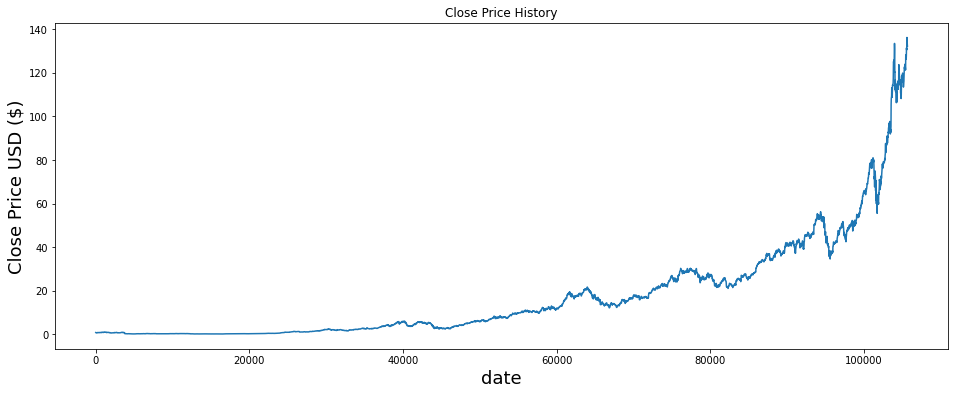

In [293]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [294]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['open','high','low','close','volume'])
# Convert the dataframe to a numpy array
dataset = data.values


In [295]:
# Hyperparameters Define:
training_data_ratio = 0.9
shift = 1
input_width = 90 # per quarter

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_idx = training_data_len + input_width - 1
print("Training data from 0 to {}".format(train_idx))

Training data from 0 to 4845


In [296]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

# reserve the 0.5 range for future stock increase space
scaler = MinMaxScaler(feature_range=(0.2,0.6))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.20204449, 0.20221986, 0.20203047, 0.20193442, 0.22689984],
       [0.20213195, 0.20217153, 0.20201716, 0.20172139, 0.2256309 ],
       [0.20201534, 0.20216992, 0.20206542, 0.20175525, 0.24004072],
       ...,
       [0.6       , 0.6       , 0.6       , 0.59466618, 0.2044272 ],
       [0.59283112, 0.59191657, 0.59719638, 0.59129593, 0.20309454],
       [0.58847756, 0.58830788, 0.5921857 , 0.58827735, 0.20323891]])

In [297]:
# Create the training data set 
# Create the scaled training data set
# Split the data into x_train and y_train data sets
def data_prepare(df, train_i, input_width, shift):
    """
    df: data frame
    train_len: training dataset length
    input_width: training time series length
    shift: offset between x and y
    """
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(input_width - 1, len(df) - shift):
        if i < train_i:
            x_train.append(df[i - input_width + 1: i + 1, 0])
            y_train.append(df[i + shift, 0])
        else:
            x_test.append(df[i - input_width + 1: i + 1, 0])
            y_test.append(df[i + shift, 0])
    
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = data_prepare(scaled_data, train_idx, input_width, shift)

(4756, 90, 1) (4756,) (438, 90, 1) (438,)


In [298]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [299]:
def compile_and_fit(x_train, y_train, model, batch_size, epochs, optimizer='adam', loss='mean_squared_error'):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer, loss=loss
    )
    
    model.summary()
    
    history = model.fit(
        x_train, y_train, 
        batch_size=batch_size,
        epochs = epochs
    )
    
    return model, history

In [300]:
models = {}
histories = {}
# Build the LSTM model
def build_simple_lstm():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (input_width, 1)))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    return model
models['simple_lstm'] = build_simple_lstm()
# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(x_train, y_train, batch_size=64, epochs=10)
models['simple_lstm'], histories['simple_lstm'] = compile_and_fit(x_train, y_train, model, batch_size=32, epochs=5)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 90, 128)           66560     
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
149/149 [==============================] - 5s 14ms/step - loss: 8.4980e-06
Epoch 2/5
149/149 [==============================] - 2s 14ms/step - loss: 1.3216e-06
Epoch 3/5
149/149 [==============================] - 2s 14ms/step - loss: 1

{'loss': [3.3759467896743445e-06, 1.3000694707443472e-06, 1.4167231938699842e-06, 1.2047822792737861e-06, 1.3124906672601355e-06]}


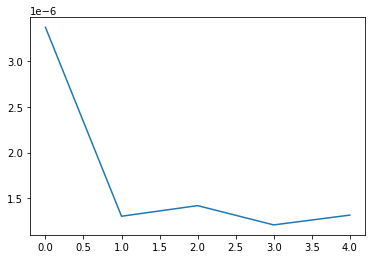

In [301]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=10)
# plotter.plot(histories['simple_lstm'])
# plt.ylim([0.5, 0.7])
plt.plot(histories['simple_lstm'].history['loss'], label='MAE (training data)')
print(histories['simple_lstm'].history)

In [302]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4756, 90, 1) (4756,) (438, 90, 1) (438,)


In [303]:
# Get the models predicted price values 
y_train_predict = model.predict(x_train)
print(y_train_predict.shape)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_train_predict - y_train) ** 2)))
print(rmse)
train_predict = scaler.inverse_transform(y_train_predict)
train_val = scaler.inverse_transform(np.reshape(y_train, (y_train.shape[0], 1)))[:, 0]
print(train_predict.shape)

(4756, 1)
0.05909097561961517


ValueError: non-broadcastable output operand with shape (4756,1) doesn't match the broadcast shape (4756,5)

In [ ]:
# Get the models predicted price values 
y_test_predict = model.predict(x_test)
print(y_test_predict.shape)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_test_predict - y_test) ** 2)))
print(rmse)
test_predict = scaler.inverse_transform(y_test_predict)
test_val = scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))[:, 0]
print(test_predict.shape)

In [ ]:
train = data[input_width + shift - 1 : len(y_train) + input_width + shift - 1]
train['predict']=train_predict
train['val']=train_val
valid = data[len(y_train) + input_width + shift - 1 :]
valid['predict'] = test_predict
valid['val']=test_val

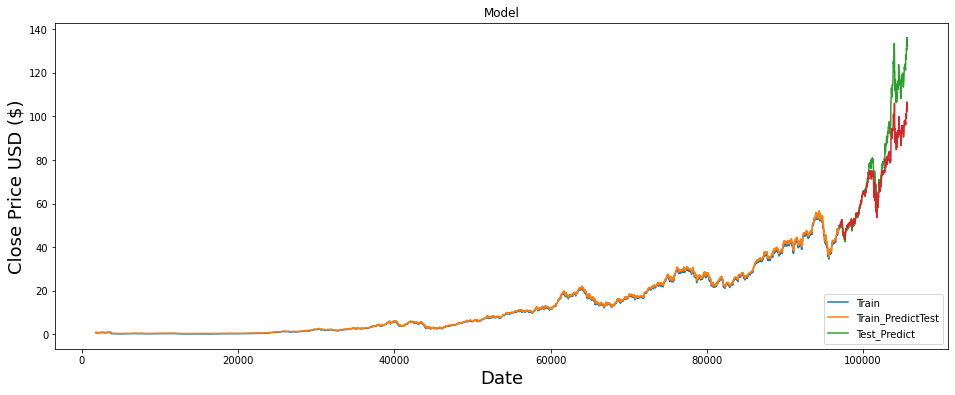

In [246]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[['val','predict']])
plt.plot(valid[['val','predict']])
plt.legend(['Train', 'Train_Predict' 'Test', 'Test_Predict'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid

In [255]:
aapl

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
20,2000-01-04,0.966518,0.987723,0.903460,0.786965,512377600.0,AAPL,1
40,2000-01-05,0.926339,0.987165,0.919643,0.798481,778321600.0,AAPL,2
60,2000-01-06,0.947545,0.955357,0.848214,0.729382,767972800.0,AAPL,3
80,2000-01-07,0.861607,0.901786,0.852679,0.763932,460734400.0,AAPL,4
...,...,...,...,...,...,...,...,...
105580,2020-12-24,131.320007,133.460007,131.100006,131.549637,54930100.0,AAPL,3
105600,2020-12-28,133.990005,137.339996,133.509995,136.254608,124486200.0,AAPL,0
105620,2020-12-29,138.050003,138.789993,134.339996,134.440399,121047300.0,AAPL,1
105640,2020-12-30,135.580002,135.990005,133.399994,133.294067,96452100.0,AAPL,2


predict target 2019-2021 2 years
predict_ds train_ds
2019-01    2000-2018-12
2019-02    2000-2019-01
2019-03    2000-2019-02
2019-04    2000-2019-03


input: ds, model, predict_time_period

logic: how to choose suitable train_dataset

output: predict_output


In [266]:
import tensorflow as tf

In [267]:
class NewGen:
    """
    train_df
    input_width: the length of time series input
    label_width: the

    """
    
    def __init__(self, train_df, test_df,
                 input_width, label_width, shift,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32, )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [268]:
data
n=len(data)
w1 = NewGen(data[0:int(n*0.7)], data[int(n*0.7):], 30, 1, 1, ['close'])

In [269]:
w1.train

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['close']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['close']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<MapDataset shapes: ((None, 30, 5), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [270]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 5)
Labels shape (batch, time, features): (32, 1, 1)
